In [1]:
#Part-1 Video/image feature extraction

In [9]:
#imports
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_score

In [1]:
# Modified to process a list of videos
"""Extract features for videos using pre-trained networks"""
from feature_extract.configs.custom_config import load_config
from slowfast.utils.misc import launch_job
from slowfast.utils.parser import parse_args
import numpy as np
import torch
import os
import time
from tqdm import tqdm
import av
from moviepy.video.io.VideoFileClip import VideoFileClip

import slowfast.utils.checkpoint as cu
import slowfast.utils.distributed as du
import slowfast.utils.logging as logging
import slowfast.utils.misc as misc

from feature_extract.models import build_model
from feature_extract.datasets.extract_dataset import VideoSet
import copy
logger = logging.get_logger(__name__)


/home/lxj/anaconda3/envs/surgplan/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/lxj/anaconda3/envs/surgplan/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


In [2]:
import os
import random
from io import BytesIO
import torch
import numpy as np
import cv2
from slowfast.datasets.utils import pack_pathway_output
from feature_extract.configs.custom_config import load_config
from slowfast.utils.parser import parse_args
from matplotlib import pyplot as plt
from collections import deque
import pandas as pd
import argparse
import sys





In [3]:
#Feature extraction configs
def parse_args():
    """
    Parse the following arguments for a default parser for PySlowFast users.
    Args:
        shard_id (int): shard id for the current machine. Starts from 0 to
            num_shards - 1. If single machine is used, then set shard id to 0.
        num_shards (int): number of shards using by the job.
        init_method (str): initialization method to launch the job with multiple
            devices. Options includes TCP or shared file-system for
            initialization. details can be find in
            https://pytorch.org/docs/stable/distributed.html#tcp-initialization
        cfg (str): path to the config file.
        opts (argument): provide addtional options from the command line, it
            overwrites the config loaded from file.
    """
    parser = argparse.ArgumentParser(
        description="Provide SlowFast video training and testing pipeline."
    )
    parser.add_argument(
        "--shard_id",
        help="The shard id of current node, Starts from 0 to num_shards - 1",
        default=0,
        type=int,
    )
    parser.add_argument(
        "--num_shards",
        help="Number of shards using by the job",
        default=1,
        type=int,
    )
    parser.add_argument(
        "--init_method",
        help="Initialization method, includes TCP or shared file-system",
        default="tcp://localhost:9999",
        type=str,
    )
    parser.add_argument(
        "--cfg",
        dest="cfg_files",
        help="Path to the config files",
        default=["/home/lxj/project/surgplan/LUO/slowfast/feature_extract/configs/SLOWFAST_8x8_R50_1031.yaml"],
        nargs="+",
    )
    parser.add_argument(
        "--opts",
        help="See slowfast/config/defaults.py for all options",
        default=None,
        nargs=argparse.REMAINDER,
    )
    parser.add_argument(
        "--f",
        help="for jupyternotebook to run",
        default=None,
        nargs=argparse.REMAINDER,
    )
    if len(sys.argv) == 1:
        parser.print_help()
    return parser.parse_args()

In [4]:
#创建一个steram output feature的方法

In [4]:
#Feature extraction image process

def pre_process_frame(arr):
        """
        Pre process an array
        Args:
            arr (ndarray): an array of frames of shape T x H x W x C 
        Returns:
            arr (tensor): a normalized torch tensor of shape C x T x H x W 
        """
        arr = torch.from_numpy(arr).float()
        # Normalize the values
        arr = arr / 255.0
        #DATA.MEAN = [0.45, 0.45, 0.45]
        arr = arr - torch.tensor([0.45, 0.45, 0.45])
        #_C.DATA.STD = [0.225, 0.225, 0.225]
        arr = arr / torch.tensor([0.225, 0.225, 0.225])

        # T H W C -> C T H W.
        try:
            arr = arr.permute(3, 0, 1, 2)
        except Exception as e:
            print("length of the array is not T x H x W x C ")

        return arr

In [11]:
#model(input)的框架

In [5]:
def calculate_time_taken(start_time, end_time):
    hours = int((end_time - start_time) / 3600)
    minutes = int((end_time - start_time) / 60) - (hours * 60)
    seconds = int((end_time - start_time) % 60)
    return hours, minutes, seconds

#feature extraction slow fast inference
@torch.no_grad()
def perform_inference(inputs, model, cfg):
    """
    Perform mutli-view testing that samples a segment of frames from a video
    and extract features from a pre-trained model.
    Args:
        test_loader (loader): video testing loader.
        model (model): the pretrained video model to test.
        cfg (CfgNode): configs. Details can be found in
            slowfast/config/defaults.py
    """
    # Enable eval mode.
    model.eval()

    feat_arr = None

    # Transfer the data to the current GPU device.
    if isinstance(inputs, (list,)):
        for i in range(len(inputs)):
            inputs[i] = inputs[i].cuda(device=cfg.USED_GPU,non_blocking=True)
    else:
        inputs = inputs.cuda(device=cfg.USED_GPU,non_blocking=True)

    # Perform the forward pass.
    preds, feat = model(inputs)
    # Gather all the predictions across all the devices to perform ensemble.
    if cfg.NUM_GPUS > 1:
        preds, feat = du.all_gather([preds, feat])

    feat = feat.cpu().numpy()

    if feat_arr is None:
        feat_arr = feat
    else:
        feat_arr = np.concatenate((feat_arr, feat), axis=0)

    return feat_arr

In [6]:
#video feature extraction stream output
def test(model,cfg,inputs):
    """
    Perform multi-view testing/feature extraction on the pretrained video model.
    Args:
        cfg (CfgNode): configs. Details can be found in
            slowfast/config/defaults.py
    """

    # Set random seed from configs.
    np.random.seed(cfg.RNG_SEED)
    torch.manual_seed(cfg.RNG_SEED)

    # Setup logging format.
    #logging.setup_logging(cfg.OUTPUT_DIR)

    # Print config.
    #logger.info("Test with config:")
    #logger.info(cfg)

    # Build the video model and print model statistics.
    
    #if du.is_master_proc() and cfg.LOG_MODEL_INFO:
        #misc.log_model_info(model, cfg, use_train_input=False)

    #changes here
    #checkpoint = torch.load("/data/disk/LUO/slowfast/feature_extract/checkpoints/checkpoint_epoch_00130.pyth")
    #model.load_state_dict(checkpoint['model_state'])

    #cu.load_test_checkpoint(cfg, model)
    # Perform multi-view test on the entire dataset.
    feat_arr = perform_inference(inputs, model, cfg)
    

    return feat_arr




In [7]:
# python imports
import argparse
import os
import glob
import time
from pprint import pprint

# torch imports
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data

# our code
from libs.core import load_tridet_config
from libs.datasets import make_dataset, make_data_loader
from libs.modeling import make_meta_arch
from libs.utils import valid_one_epoch, ANETdetection, fix_random_seed


In [8]:
#imports
import os
import json
import h5py
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset
from torch.nn import functional as F

from libs.datasets.datasets import register_dataset
from libs.datasets.data_utils import truncate_feats
from libs.utils import remove_duplicate_annotations


In [9]:
def _load_json(label_dict=None,split=['testing'],num_classes=19,json_file="/home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/data/cataract/data_1102.json",default_fps=30):

        #create a csv
        #frame_start,frame_end,label,training_or_testing
        # load database and select the subset
        with open(json_file) as f:
            json_data = json.load(f)
        # if label_dict is not available, matching label(str) to label id (int)
        if label_dict is None:
            label_dict = {
            #define surgical phase name to phase label id
                "phase_{}".format(i+1):i for i in range(num_classes)
            }
            
        if split[0] == "training":
            split_name = "train"
        else:
            split_name = "test"
        # fill in the db (immutable afterwards)
        dict_db = tuple()
        for key, value in json_data.items():
            # key is the video id, v is the segement information
            # get fps if available

            if split_name not in value["annotation"][0]["subset"]:
                continue
            if default_fps is not None:
                fps = default_fps
            else:
                #fps=30
                fps = 1

            duration = []
            num_phase = len(value["annotation"])
            segments = np.zeros([num_phase, 2], dtype=np.float32)
            labels = np.zeros([num_phase, ], dtype=np.int64)
            for idx,phase in enumerate(value["annotation"]):
                duration.append(phase["time_till_now"])
                segments[idx][0] = phase["start"]
                segments[idx][1] = phase["end"]
                if num_classes == 1:
                    labels[idx] = 0
                else:
                    labels[idx] = phase["label"]
            last_time = value["last_time"]
            dict_db += ({'id': key.split(".")[0],
                         'fps': fps,
                         'duration': last_time,
                         'segments': segments,
                         'labels': labels
                         },)

        return dict_db, label_dict

In [10]:
def getitem(data_list,features, idx,num_frames,max_seq_len=1024,feat_stride=1,downsample_rate=1,force_upsampling=False,mirror=True):
    # directly return a (truncated) data point (so it is very fast!)
    # auto batching will be disabled in the subsequent dataloader
    # instead the model will need to decide how to batch / preporcess the data
    video_item = data_list[idx]

    # load features
    feats = features

    #shape is T x 2304
    # we support both fixed length features / variable length features
    if feat_stride > 0 and (not force_upsampling):
        # var length features
        feat_stride, num_frames = feat_stride, num_frames
        # only apply down sampling here
        if downsample_rate > 1:
            feats = feats[::downsample_rate, :]
            feat_stride = feat_stride * downsample_rate

    # T x C -> C x T
    if isinstance(feats, torch.Tensor):
        feats = feats.transpose(0, 1)
    else:
        feats = torch.from_numpy(np.ascontiguousarray(feats.transpose()))

    # convert time stamp (in second) into temporal feature grids
    # ok to have small negative values here
    if video_item['segments'] is not None:
        segments = torch.from_numpy(
            #(video_item['segments'] * video_item['fps'] - 0.5 * num_frames) / (feat_stride)
            video_item['segments']
        )
        labels = torch.from_numpy(video_item['labels'])
        # for activity net, we have a few videos with a bunch of missing frames
        # here is a quick fix for training
        segments, labels = None, None

    # return a data dict
    data_dict = {'video_id': video_item['id'],
                    'feats': feats,  # C x T
                    'segments': segments,  # N x 2
                    'labels': labels,  # N
                    'fps': 30,
                    'duration': num_frames,
                    'feat_stride': 30,
                    'feat_num_frames': 32}


    return data_dict


In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value.
    Used to compute dataset stats from mini-batches
    """

    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = 0.0

    def initialize(self, val, n):
        self.val = val
        self.avg = val
        self.sum = val * n
        self.count = n
        self.initialized = True

    def update(self, val, n=1):
        if not self.initialized:
            self.initialize(val, n)
        else:
            self.add(val, n)

    def add(self, val, n):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def valid_one_epoch(
        dict_db,
        model,
        curr_epoch=0,
        ext_score_file=None,
        evaluator=None,
        output_file=None,
        tb_writer=None,
        print_freq=20
):
    """Test the model on the validation set"""
    # either evaluate the results or save the results

    # set up meters
    batch_time = AverageMeter()
    # switch to evaluate mode
    model.eval()
    # dict for results (for our evaluation code)
    results = {
        'video-id': [],
        't-start': [],
        't-end': [],
        'label': [],
        'score': []
    }

    # loop over validation set
    start = time.time()
        # forward the model (wo. grad)
    with torch.no_grad():
        output = model(dict_db)

        # upack the results into ANet format
        num_vids = len(output)
        for vid_idx in range(num_vids):
            if output[vid_idx]['segments'].shape[0] > 0:
                results['video-id'].extend(
                    [output[vid_idx]['video_id']] *
                    output[vid_idx]['segments'].shape[0]
                )
                results['t-start'].append(output[vid_idx]['segments'][:, 0])
                results['t-end'].append(output[vid_idx]['segments'][:, 1])
                results['label'].append(output[vid_idx]['labels'])
                results['score'].append(output[vid_idx]['scores'])


    # gather all stats and evaluate
    results['t-start'] = torch.cat(results['t-start']).numpy()
    results['t-end'] = torch.cat(results['t-end']).numpy()
    results['label'] = torch.cat(results['label']).numpy()
    results['score'] = torch.cat(results['score']).numpy()

    return results


In [13]:
import os
import json
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from typing import List
from typing import Tuple
from typing import Dict
import datetime


In [14]:
def load_gt_seg_from_json(json_file, split=None, label='label', label_offset=0):
    # load json file
    with open(json_file, "r", encoding="utf8") as f:
        json_db = json.load(f)

    vids, starts, stops, labels = [], [], [], []
    if split == "training":
        split_name = "train"
    else:
        split_name = "test"
    for k, v in json_db.items():

        for segments in v["annotation"]:
            if split_name not in segments["subset"]:
                continue
            ants = segments
            vids.append(k.split(".")[0])
            starts.append(ants["start"])
            stops.append(ants["end"])
            labels.append(ants["label"])



        """# filter based on split
        if split_name not in k:
            continue
        # remove duplicated instances
        ants = v
        # video id
        vids += [k] * len(ants)
        # for each event, grab the start/end time and label
        for event in ants:
            starts += [float(event['start'])]
            stops += [float(event['end'])]
            if isinstance(event[label], (Tuple, List)):
                # offset the labels by label_offset
                label_id = 0
                for i, x in enumerate(event[label][::-1]):
                    label_id += label_offset ** i + int(x)
            else:
                # load label_id directly
                label_id = int(event[label])
            labels += [label_id]"""

    # move to pd dataframe
    gt_base = pd.DataFrame({
        'video-id': vids,
        't-start': starts,
        't-end': stops,
        'label': labels
    })

    return gt_base

In [15]:
def to_df(preds):
        """Evaluates a prediction file. For the detection task we measure the
        interpolated mean average precision to measure the performance of a
        method.
        preds can be (1) a pd.DataFrame; or (2) a json file where the data will be loaded;
        or (3) a python dict item with numpy arrays as the values
        """

        if isinstance(preds, Dict):
            # move to pd dataframe
            # did not check dtype here, can accept both numpy / pytorch tensors
            preds = pd.DataFrame({
                'video-id': preds['video-id'],
                't-start': preds['t-start'].tolist(),
                't-end': preds['t-end'].tolist(),
                'label': preds['label'].tolist(),
                'score': preds['score'].tolist()
            })



        return preds


In [16]:
def calculate_acc(pred_df,gt_df):
    with open("/home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/data/cataract/data_1102.json","r") as f:
        gt_json = json.load(f)
    df_gt= pd.DataFrame(columns=["video_id","gt_labels"])
    for k,v in gt_json.items():
        if "train" in k:
            continue
        dur = v["last_time"]
        video_name = k.split(".")[0]
        gt_labels = [0 for i in range(int(np.round(dur)))]
        video_id = [k for i in range(int(np.round(dur)))]
        df = pd.DataFrame(columns=["video_id","gt_labels"])
        df["video_id"] = video_id
        df["gt_labels"] = gt_labels
        subset = gt_df[gt_df["video-id"]==video_name]
        
        for index in subset.index:
            start = int(np.round(subset.loc[index]["t-start"]))
            end = int(np.round(subset.loc[index]["t-end"]))
            label = subset.loc[index]["label"]
            for i in range(start,end+1):
                df.loc[i,"gt_labels"] = label+1
        
        df_gt = pd.concat([df_gt,df],ignore_index=True)    
    df_pred = pd.DataFrame(columns=["video_id","pred_labels"])


    for k,v in gt_json.items():
        if "train" in k:
            continue
        video_name = k.split(".")[0]
        dur = v["last_time"]
        gt_labels = [0 for i in range(int(np.round(dur)))]
        video_id = [k for i in range(int(np.round(dur)))]
        df = pd.DataFrame(columns=["video_id","pred_labels"])
        df["video_id"] = video_id
        df["pred_labels"] = gt_labels
        subset = pred_df[pred_df["video-id"]==video_name]
        
        for index in subset.index:
            start = int(np.round(subset.loc[index]["t-start"]))
            end = int(np.round(subset.loc[index]["t-end"]))
            label = subset.loc[index]["label"]
            for i in range(start,end+1):
                if i>=len(df):
                    continue
                df.loc[i,"pred_labels"] = label+1
        #print(df)
        df_pred = pd.concat([df_pred,df],ignore_index=True)


    return df_pred
    """
    df_all =pd.concat([df_gt,df_pred["pred_labels"]],axis=1)
    acc = accuracy_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list())
    f1 = f1_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list(),average="macro")
    recall = recall_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list(),average="macro")
    precision = precision_score(df_all["gt_labels"].to_list(),df_all["pred_labels"].to_list(),average="macro")
    df_pred.to_csv("df_pred.csv",index=False)
    df_gt.to_csv("df_gt.csv",index=False)
    print("accuracy under the threshold : ", acc,end="     ")
    print("f1 score under the threshold : ", f1,end="     ")
    print("precision score under the threshold : ", precision,end="     ")
    print("recall score under the threshold : ", recall)
    """

In [17]:
def get_middle_label(pred_df,mid_index,threshold=0.22):
    df = pred_df[pred_df["score"]>threshold]
    label = 0
    score = threshold
    s = mid_index[0]
    e = mid_index[1]
    #filter df
    if len(df) == 0:
        for i in range(len(pred_df)):
            if pred_df.iloc[i]["t-start"]<=e and pred_df.iloc[i]["t-end"]>=s:
                label = 0
                score = pred_df.iloc[i]["score"]
                break
    for i in range(len(df)):
        if df.iloc[i]["t-start"]<=e and df.iloc[i]["t-end"]>=s:
            label = df.iloc[i]["label"]
            score = df.iloc[i]["score"]
            break
    return label,score


In [26]:
"""def get_middle_label(pred_df,mid_index,threshold=0.22):
    df = pred_df[pred_df["score"]>threshold]
    label = 0
    s = mid_index[0]
    e = mid_index[1]
    #filter df
    for i in range(len(df)):
        if mid_index>=df.iloc[i]["t-start"] and mid_index <= df.iloc[i]["t-end"]:
            label = df.iloc[i]["label"]
            break
    return label"""

'def get_middle_label(pred_df,mid_index,threshold=0.22):\n    df = pred_df[pred_df["score"]>threshold]\n    label = 0\n    s = mid_index[0]\n    e = mid_index[1]\n    #filter df\n    for i in range(len(df)):\n        if mid_index>=df.iloc[i]["t-start"] and mid_index <= df.iloc[i]["t-end"]:\n            label = df.iloc[i]["label"]\n            break\n    return label'

In [18]:
#deprecated
def mirror_feature(inputs,reversed_inputs,filled_inputs,num_fill):
    feat = inputs["feats"]
    feat_flipped = torch.from_numpy(reversed_inputs)
    feat_flipped = feat_flipped.transpose(0, 1)
    if num_fill>0:
        feat_fill = np.repeat(filled_inputs,num_fill,axis=0)
        
        feat_fill = torch.from_numpy(feat_fill)
        feat_fill = feat_fill.transpose(0, 1)
        feat_mirrored = torch.concat((feat, feat_fill,feat_flipped), dim=1)
        if feat_mirrored.size(1)>1024:
            center = feat_mirrored.size(1)//2
            start_index = center-512
            end_index = center+512
            feat_mirrored = feat_mirrored[:, start_index:end_index]
            inputs["feats"] = feat_mirrored
            inputs['duration'] = 1024
            return inputs
        inputs["feats"] = feat_mirrored
        inputs['duration'] = inputs['duration']*2+num_fill
        
    else:
        feat_mirrored = torch.concat((feat, feat_fill,feat_flipped), dim=1)
        inputs["feats"] = feat_mirrored
        inputs['duration'] = inputs['duration']*2
    return inputs

In [82]:
def mirror_feature(inputs,reversed_inputs,filled_inputs,num_fill):
    feat = inputs["feats"]
    feat_flipped = torch.from_numpy(reversed_inputs)
    feat_flipped = feat_flipped.transpose(0, 1)
    if num_fill>0:
        feat_fill = np.repeat(filled_inputs,num_fill,axis=0)
        
        feat_fill = torch.from_numpy(feat_fill)
        feat_fill = feat_fill.transpose(0, 1)
        feat_mirrored = torch.concat((feat, feat_fill,feat_flipped), dim=1)
        inputs["feats"] = feat_mirrored
        inputs['duration'] = inputs['duration']*2+num_fill
        ratio = inputs["duration"]//512+1
        inputs["feats"] = feat_mirrored[:,::ratio]
        inputs['duration'] = len(inputs["feats"])
    else:
        feat_mirrored = torch.concat((feat,feat_flipped), dim=1)
        inputs["feats"] = feat_mirrored
        inputs['duration'] = inputs['duration']*2
        ratio = inputs["duration"]//512+1
        inputs["feats"] = feat_mirrored[:,::ratio]
        inputs['duration'] = len(inputs["feats"])
    return inputs

In [65]:
def fill_feature(inputs,filled_inputs,num_fill):
    feat = inputs["feats"]
    feat_fill = np.repeat(filled_inputs,num_fill,axis=0)
    feat_fill = torch.from_numpy(feat_fill)
    feat_fill = feat_fill.transpose(0, 1)
    feat_filled = torch.concat((feat, feat_fill), dim=1)
    inputs["feats"] = feat_filled
    inputs['duration'] = inputs['duration']+num_fill
    ratio = inputs["duration"]//512+1
    inputs["feats"] = feat_filled[:,::ratio]
    inputs['duration'] = len(inputs["feats"])
    return inputs

In [20]:
#deprecated
def fill_feature(inputs,fill_n_times=3):
        #return the mirrored inputs, e.g (2304,100) -> (2304,200)
    feat = inputs["feats"]
    feat_fill = np.repeat(filled_inputs,num_fill,axis=0)
    feat_fill = torch.from_numpy(feat_fill)
    feat_fill = feat_fill.transpose(0, 1)
    feat_mirrored = torch.concat((feat, feat_fill), dim=1)
    """if feat_mirrored.size(1)>1024:
            center = feat_mirrored.size(1)//2
            start_index = center-512
            end_index = center+512
            feat_mirrored = feat_mirrored[:, start_index:end_index]
            inputs["feats"] = feat_mirrored
            inputs['duration'] = 1024
            return inputs"""
    inputs["feats"] = feat_mirrored
    inputs['duration'] = inputs['duration']+num_fill
    return inputs

In [21]:
#Feature extraction configs
args = parse_args()
cfg = load_config(args)
cfg.USED_GPU = 4 #make sure it is same as device
vid_path = "/home/lxj/project/surgplan/LUO/cataract_test_video/test03.mp4"

#tridet_cfg = load_tridet_config("/data/disk/LUO/test_only/TriDet/configs/cataract_slowfast.yaml")

#ckpt_file = '/data/disk/LUO/epoch_110_best.pth.tar'

tridet_cfg = load_tridet_config("/home/lxj/project/surgplan/LUO/test_only/TriDet/configs/cataract_slowfast_0219.yaml")
ckpt_file = '/home/lxj/project/surgplan/LUO/test_only/TriDet/ckpt/cataract_slowfast_0219_redivide/epoch_100.pth.tar'
topk=-1
tridet_cfg['model']['test_cfg']['max_seg_num'] = topk
print_freq = 10
save_only = False

# fix the random seeds (this will fix everything)
_ = fix_random_seed(0, include_cuda=True)


In [ ]:
#debug only

device = "cuda:7"
cap = cv2.VideoCapture(vid_path)
sample_height = 256
sample_width = 256
count = 0
seq_length = 32
queue = deque(maxlen=64)
ret = True
frame_wise_feature = None
extract_model = build_model(cfg).to(device)
print("loading feature extraction model")
extract_checkpoint = torch.load("/data/disk/LUO/slowfast/feature_extract/checkpoints/checkpoint_epoch_00130.pyth",map_location=device)
extract_model.load_state_dict(extract_checkpoint['model_state'])
del extract_checkpoint
idx = int(vid_path.split("/")[-1].split(".")[0].split("test")[-1])-1 #test01 -> 0
dict_db,label_dict = _load_json() #dict_db contains segments and labels
current_db = dict_db[idx] #current test file json
count_2 = 0 #count after queue is full
num_fill = 32
# load tridet model
model = make_meta_arch(tridet_cfg['model_name'], **tridet_cfg['model'])
# not ideal for multi GPU training, ok for now
model = nn.DataParallel(model, device_ids=tridet_cfg['devices'])
print("=> loading checkpoint '{}'".format(ckpt_file))
# load ckpt, reset epoch / best rmse
checkpoint = torch.load(
    ckpt_file,
    map_location=lambda storage, loc: storage.cuda(tridet_cfg['devices'][0])
)

# load ema model instead
print("Loading from EMA model ...")
model.load_state_dict(checkpoint['state_dict_ema'])
del checkpoint
pure_pred_list = []
fill_pred_list = []
pred_list = []
start = datetime.datetime.now()
while ret:
    #print("count: ",count)
    
    ret,frame = cap.read()
    if not ret:
        print("finished")
        break
    height, width = frame.shape[:2]
    frame = cv2.resize(frame,(sample_height,sample_width),interpolation = cv2.INTER_LINEAR)
    queue.append(frame)
    if count<64:
        count+=1
        continue
    else:
        frames = np.stack(queue, axis=0)
        frames = frames[::2,:,:,:]
        reversed_frames = np.flip(frames, axis=0)
        reversed_frames = reversed_frames.copy()
        filled_frames = np.expand_dims(frame, axis=0)
        filled_frames = np.repeat(filled_frames, 32, axis=0)
        #print(frames.shape)
        #print(reversed_frames.shape)
        #print(filled_frames.shape)
        frames = pre_process_frame(frames)
        reversed_frames = pre_process_frame(reversed_frames)
        filled_frames = pre_process_frame(filled_frames)
        
        frame_list = pack_pathway_output(cfg, frames) #得到一个list,list[0]为(3,8,256,256),[1]为[3,32,256,256]分别表示slow和fast两条线
        frame_list[0] = frame_list[0].unsqueeze(0) #增加一个batch维度
        frame_list[1] = frame_list[1].unsqueeze(0)

        reversed_frame_list = pack_pathway_output(cfg, reversed_frames)
        reversed_frame_list[0] = reversed_frame_list[0].unsqueeze(0) #增加一个batch维度
        reversed_frame_list[1] = reversed_frame_list[1].unsqueeze(0)     

        filled_frame_list = pack_pathway_output(cfg, filled_frames)
        filled_frame_list[0] = filled_frame_list[0].unsqueeze(0) #增加一个batch维度
        filled_frame_list[1] = filled_frame_list[1].unsqueeze(0)   


        if count_2%30 == 0: #每30表示的是每30个frame，即每一秒取一次feature
            cur_second = count//30
            print("current second: ",cur_second+2)
            if frame_wise_feature is None:
                frame_wise_feature = test(extract_model,cfg,frame_list) #得到每32个frame为单位的一个feature，size大小为(1,2304)
                reversed_frame_wise_feature = test(extract_model,cfg,reversed_frame_list)
                filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                #print("frame_wise_feture",frame_wise_feture.shape)
                #print(test(cfg,frame_list))
            else:
                #print("frame_wise_feture ",frame_wise_feture.shape)
                cur_feature = test(extract_model,cfg,frame_list)
                reversed_cur_feature = test(extract_model,cfg,reversed_frame_list)
                #print("cur_feature ",cur_feature.shape)
                frame_wise_feature = np.concatenate((frame_wise_feature,cur_feature),axis=0)
                reversed_frame_wise_feature =  np.concatenate((reversed_cur_feature,reversed_frame_wise_feature),axis=0)

                filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                #print(reversed_frame_wise_feature.shape)
                #print(filled_frame_wise_feature.shape)
                #print(frame_wise_feture.shape)
                #将frame_wise_feature 在dim 0 上concate起来，放入surgplan的eval方程
            
            
            #transfer input frame_wise_features into dictionary
            inputs = getitem(data_list=dict_db,features=frame_wise_feature, idx=idx,num_frames=len(frame_wise_feature))
            results = valid_one_epoch([inputs],model=model)
            df_1 = to_df(results)
            pred_label,score = get_middle_label(df_1,[cur_second-2,cur_second],threshold=0.15)
            pure_pred_list.append(pred_label)
            print("no mirror predicted label: ",pred_label," score:",score)
            #ret = False
            #inference

            mirror_features = mirror_feature(inputs,reversed_frame_wise_feature,filled_frame_wise_feature,num_fill)
            results = valid_one_epoch([mirror_features],model=model)
            df = to_df(results)
            if inputs["feats"].size(1) >= 1024:
                pred_label,score = get_middle_label(df,[512-num_fill//2,512+num_fill//2],0.15)
            else:
                pred_label,score = get_middle_label(df,[cur_second+num_fill-2,cur_second+num_fill],threshold=0.15)

            print("mirror predicted label: ",pred_label," score:",score)
            print()
            pred_list.append(pred_label)
        count+=1
        count_2 +=1 
end = datetime.datetime.now()

print("total time: ", (end-start).seconds)



In [24]:
#debug only
gt = pd.read_csv("/home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/df_gt.csv")

In [37]:
#debug only
accuracy_score(gt[gt["video_id"]=="test03.mp4"]["gt_labels"][-len(pred_list):],pure_pred_list[:])

0.3652694610778443

In [ ]:
#debug only
#Feature extraction configs
args = parse_args()
cfg = load_config(args)
cfg.USED_GPU = 1 #make sure it is same as device

#tridet_cfg = load_tridet_config("/data/disk/LUO/test_only/TriDet/configs/cataract_slowfast.yaml")
#ckpt_file = '/data/disk/LUO/epoch_110_best.pth.tar'

tridet_cfg = load_tridet_config("/home/lxj/project/surgplan/LUO/test_only/TriDet/configs/cataract_slowfast_reverse.yaml")
ckpt_file = '/home/lxj/project/surgplan/LUO/test_only/TriDet/ckpt/cataract_slowfast_reverse_reverse/epoch_080.pth.tar'

topk=-1
print_freq = 10
save_only = False

# fix the random seeds (this will fix everything)
_ = fix_random_seed(0, include_cuda=True)


In [25]:
device = "cuda:4"
extract_model = build_model(cfg).to(device)
extract_checkpoint = torch.load("/home/lxj/project/surgplan/LUO/slowfast/feature_extract/checkpoints/checkpoint_epoch_00130.pyth",map_location=device)
print("Loading from Feature Extraction Model ...")
extract_model.load_state_dict(extract_checkpoint['model_state'])
del extract_checkpoint
model = make_meta_arch(tridet_cfg['model_name'], **tridet_cfg['model'])
model = nn.DataParallel(model, device_ids=tridet_cfg['devices'])
print("=> loading checkpoint '{}'".format(ckpt_file))
checkpoint = torch.load(
    ckpt_file,
    map_location=lambda storage, loc: storage.cuda(tridet_cfg['devices'][0])
)
print("loading finish")
# load ema model instead
print("Loading from EMA model ...")
model.load_state_dict(checkpoint['state_dict_ema'])
del checkpoint
print("loading finish")
gt = pd.read_csv("/home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/df_gt.csv")
dir_name = "/home/lxj/project/surgplan/LUO/cataract_test_video"

Loading from Feature Extraction Model ...
=> loading checkpoint '/home/lxj/project/surgplan/LUO/test_only/TriDet/ckpt/cataract_slowfast_0219_redivide/epoch_100.pth.tar'
loading finish
Loading from EMA model ...
loading finish


In [34]:
def main_pure(vid,log_folder,threshold=0.1,num_fill=32):    
    print("Eval video: ",vid," ...")
    vid_path = os.path.join(dir_name,vid)
    device = "cuda:0"
    cap = cv2.VideoCapture(vid_path)
    sample_height = 256
    sample_width = 256
    count = 0
    seq_length = 32
    queue = deque(maxlen=64)
    ret = True
    frame_wise_feature = None
    idx = int(vid_path.split("/")[-1].split(".")[0].split("test")[-1])-1 #test01 -> 0
    dict_db,label_dict = _load_json() #dict_db contains segments and labels
    current_db = dict_db[idx] #current test file json
    count_2 = 0 #count after queue is full
    # load tridet model
    # not ideal for multi GPU training, ok for now

    # load ckpt, reset epoch / best rmse


    pred_list = []
    score_list = []
    start = datetime.datetime.now()
    while ret:
        #print("count: ",count)
        
        ret,frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        frame = cv2.resize(frame,(sample_height,sample_width),interpolation = cv2.INTER_LINEAR)
        queue.append(frame)
        if count<64:
            count+=1
            continue
        else:
            frames = np.stack(queue, axis=0)
            frames = frames[::2,:,:,:]
            #reversed_frames = np.flip(frames, axis=0)
            #reversed_frames = reversed_frames.copy()
            #filled_frames = np.expand_dims(frame, axis=0)
            #filled_frames = np.repeat(filled_frames, 32, axis=0)
            #print(frames.shape)
            #print(reversed_frames.shape)
            #print(filled_frames.shape)
            frames = pre_process_frame(frames)
            #reversed_frames = pre_process_frame(reversed_frames)
            #filled_frames = pre_process_frame(filled_frames)
            
            frame_list = pack_pathway_output(cfg, frames) #得到一个list,list[0]为(3,8,256,256),[1]为[3,32,256,256]分别表示slow和fast两条线
            frame_list[0] = frame_list[0].unsqueeze(0) #增加一个batch维度
            frame_list[1] = frame_list[1].unsqueeze(0)

            #reversed_frame_list = pack_pathway_output(cfg, reversed_frames)
            #reversed_frame_list[0] = reversed_frame_list[0].unsqueeze(0) #增加一个batch维度
            #reversed_frame_list[1] = reversed_frame_list[1].unsqueeze(0)     

            #filled_frame_list = pack_pathway_output(cfg, filled_frames)
            #filled_frame_list[0] = filled_frame_list[0].unsqueeze(0) #增加一个batch维度
            #filled_frame_list[1] = filled_frame_list[1].unsqueeze(0)   


            if count_2%30 == 0: #每30表示的是每30个frame，即每一秒取一次feature
                cur_second = count//30
                if frame_wise_feature is None:
                    frame_wise_feature = test(extract_model,cfg,frame_list) #得到每32个frame为单位的一个feature，size大小为(1,2304)
                    #reversed_frame_wise_feature = test(extract_model,cfg,reversed_frame_list)
                    #filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print("frame_wise_feture",frame_wise_feture.shape)
                    #print(test(cfg,frame_list))
                else:
                    #print("frame_wise_feture ",frame_wise_feture.shape)
                    cur_feature = test(extract_model,cfg,frame_list)
                    #reversed_cur_feature = test(extract_model,cfg,reversed_frame_list)
                    #print("cur_feature ",cur_feature.shape)
                    frame_wise_feature = np.concatenate((frame_wise_feature,cur_feature),axis=0)
                    #reversed_frame_wise_feature =  np.concatenate((reversed_cur_feature,reversed_frame_wise_feature),axis=0)

                    #filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print(reversed_frame_wise_feature.shape)
                    #print(filled_frame_wise_feature.shape)
                    #print(frame_wise_feture.shape)
                    #将frame_wise_feature 在dim 0 上concate起来，放入surgplan的eval方程
                
                
                #transfer input frame_wise_features into dictionary
                
                inputs = getitem(data_list=dict_db,features=frame_wise_feature, idx=idx,num_frames=len(frame_wise_feature))
                #inference
                #mirror_features = mirror_feature(inputs,reversed_frame_wise_feature,filled_frame_wise_feature,num_fill)
                if inputs["feats"].size(1) >= 1024:
                    inputs["feats"] = inputs["feats"][:, -1024:]
                    inputs['duration'] = 1024
                    results = valid_one_epoch([inputs],model=model)
                    df = to_df(results)
                    pred_label,score = get_middle_label(df,[1022,1024],threshold)
                else:
                    results = valid_one_epoch([inputs],model=model)
                    df = to_df(results)
                    pred_label,score = get_middle_label(df,[cur_second-2,cur_second],threshold=threshold)

                pred_list.append(pred_label)
                score_list.append(score)
            count+=1
            count_2 +=1 
    end = datetime.datetime.now()
    cap.release()
    print("total time: ", (end-start).seconds)
    acc = accuracy_score(gt[gt["video_id"]==vid]["gt_labels"][-len(pred_list):],pred_list[:])
    print("accuracy for vid: ",vid," is : ",acc)
    x = gt[gt["video_id"]==vid][-len(pred_list):]
    x["pred_labels"] = pred_list
    x["pred_scores"] = score_list

    csv_file = "./"+log_folder+"/result_real_time_"+vid+".csv"
    x.to_csv(csv_file)

In [66]:
def main_fill(vid,log_folder,threshold=0.1,num_fill=32):    
    print("Eval video: ",vid," ...")
    vid_path = os.path.join(dir_name,vid)
    device = "cuda:0"
    cap = cv2.VideoCapture(vid_path)
    sample_height = 256
    sample_width = 256
    count = 0
    seq_length = 32
    queue = deque(maxlen=64)
    ret = True
    frame_wise_feature = None
    idx = int(vid_path.split("/")[-1].split(".")[0].split("test")[-1])-1 #test01 -> 0
    dict_db,label_dict = _load_json() #dict_db contains segments and labels
    current_db = dict_db[idx] #current test file json
    count_2 = 0 #count after queue is full
    # load tridet model
    # not ideal for multi GPU training, ok for now

    # load ckpt, reset epoch / best rmse


    pred_list = []
    score_list = []
    start = datetime.datetime.now()
    while ret:
        #print("count: ",count)
        
        ret,frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        frame = cv2.resize(frame,(sample_height,sample_width),interpolation = cv2.INTER_LINEAR)
        queue.append(frame)
        if count<64:
            count+=1
            continue
        else:
            frames = np.stack(queue, axis=0)
            frames = frames[::2,:,:,:]
            #reversed_frames = np.flip(frames, axis=0)
            #reversed_frames = reversed_frames.copy()
            filled_frames = np.expand_dims(frame, axis=0)
            filled_frames = np.repeat(filled_frames, 32, axis=0)
            #print(frames.shape)
            #print(reversed_frames.shape)
            #print(filled_frames.shape)
            frames = pre_process_frame(frames)
            #reversed_frames = pre_process_frame(reversed_frames)
            filled_frames = pre_process_frame(filled_frames)
            
            frame_list = pack_pathway_output(cfg, frames) #得到一个list,list[0]为(3,8,256,256),[1]为[3,32,256,256]分别表示slow和fast两条线
            frame_list[0] = frame_list[0].unsqueeze(0) #增加一个batch维度
            frame_list[1] = frame_list[1].unsqueeze(0)

            #reversed_frame_list = pack_pathway_output(cfg, reversed_frames)
            #reversed_frame_list[0] = reversed_frame_list[0].unsqueeze(0) #增加一个batch维度
            #reversed_frame_list[1] = reversed_frame_list[1].unsqueeze(0)     

            filled_frame_list = pack_pathway_output(cfg, filled_frames)
            filled_frame_list[0] = filled_frame_list[0].unsqueeze(0) #增加一个batch维度
            filled_frame_list[1] = filled_frame_list[1].unsqueeze(0)   


            if count_2%30 == 0: #每30表示的是每30个frame，即每一秒取一次feature
                cur_second = count//30
                if frame_wise_feature is None:
                    frame_wise_feature = test(extract_model,cfg,frame_list) #得到每32个frame为单位的一个feature，size大小为(1,2304)
                    #reversed_frame_wise_feature = test(extract_model,cfg,reversed_frame_list)
                    filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print("frame_wise_feture",frame_wise_feture.shape)
                    #print(test(cfg,frame_list))
                else:
                    #print("frame_wise_feture ",frame_wise_feture.shape)
                    cur_feature = test(extract_model,cfg,frame_list)
                    #reversed_cur_feature = test(extract_model,cfg,reversed_frame_list)
                    #print("cur_feature ",cur_feature.shape)
                    frame_wise_feature = np.concatenate((frame_wise_feature,cur_feature),axis=0)
                    #reversed_frame_wise_feature =  np.concatenate((reversed_cur_feature,reversed_frame_wise_feature),axis=0)
                    filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print(reversed_frame_wise_feature.shape)
                    #print(filled_frame_wise_feature.shape)
                    #print(frame_wise_feture.shape)
                    #将frame_wise_feature 在dim 0 上concate起来，放入surgplan的eval方程
                
                
                #transfer input frame_wise_features into dictionary
                
                inputs = getitem(data_list=dict_db,features=frame_wise_feature, idx=idx,num_frames=len(frame_wise_feature))
                #inference
                #mirror_features = mirror_feature(inputs,reversed_frame_wise_feature,filled_frame_wise_feature,num_fill)
                filled_inputs = fill_feature(inputs,filled_frame_wise_feature,num_fill)
                if filled_inputs["feats"].size(1) >= 512:
                    filled_inputs["feats"] = filled_inputs["feats"][:, -512:]
                    filled_inputs['duration'] = 512
                    results = valid_one_epoch([filled_inputs],model=model)
                    df = to_df(results)
                    pred_label,score = get_middle_label(df,[510,512],threshold)
                else:
                    results = valid_one_epoch([filled_inputs],model=model)
                    df = to_df(results)
                    pred_label,score = get_middle_label(df,[cur_second-2,cur_second],threshold=threshold)


                pred_list.append(pred_label)
                score_list.append(score)
            count+=1
            count_2 +=1 
    end = datetime.datetime.now()
    cap.release()
    print("total time: ", (end-start).seconds)
    acc = accuracy_score(gt[gt["video_id"]==vid]["gt_labels"][-len(pred_list):],pred_list[:])
    print("accuracy for vid: ",vid," is : ",acc)
    x = gt[gt["video_id"]==vid][-len(pred_list):]
    x["pred_labels"] = pred_list
    x["pred_scores"] = score_list

    csv_file = "./"+log_folder+"/result_real_time_"+vid+".csv"
    x.to_csv(csv_file)

In [80]:
def main_mirror(vid,log_folder,threshold=0.1,num_fill=32):    
    print("Eval video: ",vid," ...")
    vid_path = os.path.join(dir_name,vid)
    device = "cuda:4"
    cap = cv2.VideoCapture(vid_path)
    sample_height = 256
    sample_width = 256
    count = 0
    seq_length = 32
    queue = deque(maxlen=64)
    ret = True
    frame_wise_feature = None
    idx = int(vid_path.split("/")[-1].split(".")[0].split("test")[-1])-1 #test01 -> 0
    dict_db,label_dict = _load_json() #dict_db contains segments and labels
    current_db = dict_db[idx] #current test file json
    count_2 = 0 #count after queue is full
    # load tridet model
    # not ideal for multi GPU training, ok for now

    # load ckpt, reset epoch / best rmse


    pred_list = []
    score_list = []
    start = datetime.datetime.now()
    while ret:
        #print("count: ",count)
        
        ret,frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        frame = cv2.resize(frame,(sample_height,sample_width),interpolation = cv2.INTER_LINEAR)
        queue.append(frame)
        if count<64:
            count+=1
            continue
        else:
            frames = np.stack(queue, axis=0)
            frames = frames[::2,:,:,:]
            reversed_frames = np.flip(frames, axis=0)
            reversed_frames = reversed_frames.copy()
            filled_frames = np.expand_dims(frame, axis=0)
            filled_frames = np.repeat(filled_frames, 32, axis=0)
            #print(frames.shape)
            #print(reversed_frames.shape)
            #print(filled_frames.shape)
            frames = pre_process_frame(frames)
            reversed_frames = pre_process_frame(reversed_frames)
            filled_frames = pre_process_frame(filled_frames)
            
            frame_list = pack_pathway_output(cfg, frames) #得到一个list,list[0]为(3,8,256,256),[1]为[3,32,256,256]分别表示slow和fast两条线
            frame_list[0] = frame_list[0].unsqueeze(0) #增加一个batch维度
            frame_list[1] = frame_list[1].unsqueeze(0)

            reversed_frame_list = pack_pathway_output(cfg, reversed_frames)
            reversed_frame_list[0] = reversed_frame_list[0].unsqueeze(0) #增加一个batch维度
            reversed_frame_list[1] = reversed_frame_list[1].unsqueeze(0)     

            filled_frame_list = pack_pathway_output(cfg, filled_frames)
            filled_frame_list[0] = filled_frame_list[0].unsqueeze(0) #增加一个batch维度
            filled_frame_list[1] = filled_frame_list[1].unsqueeze(0)   


            if count_2%30 == 0: #每30表示的是每30个frame，即每一秒取一次feature
                cur_second = count//30
                if frame_wise_feature is None:
                    frame_wise_feature = test(extract_model,cfg,frame_list) #得到每32个frame为单位的一个feature，size大小为(1,2304)
                    reversed_frame_wise_feature = test(extract_model,cfg,reversed_frame_list)
                    filled_frame_wise_feature = None
                    #print("frame_wise_feture",frame_wise_feture.shape)
                    #print(test(cfg,frame_list))
                else:
                    #print("frame_wise_feture ",frame_wise_feture.shape)
                    cur_feature = test(extract_model,cfg,frame_list)
                    reversed_cur_feature = test(extract_model,cfg,reversed_frame_list)
                    #print("cur_feature ",cur_feature.shape)
                    frame_wise_feature = np.concatenate((frame_wise_feature,cur_feature),axis=0)
                    reversed_frame_wise_feature =  np.concatenate((reversed_cur_feature,reversed_frame_wise_feature),axis=0)
                    filled_frame_wise_feature = None
                    #print(reversed_frame_wise_feature.shape)
                    #print(filled_frame_wise_feature.shape)
                    #print(frame_wise_feture.shape)
                    #将frame_wise_feature 在dim 0 上concate起来，放入surgplan的eval方程
                
                
                #transfer input frame_wise_features into dictionary
                
                inputs = getitem(data_list=dict_db,features=frame_wise_feature, idx=idx,num_frames=len(frame_wise_feature))
                #inference
                mirror_features = mirror_feature(inputs,reversed_frame_wise_feature,filled_frame_wise_feature,num_fill)
                #filled_inputs = fill_feature(inputs,filled_frame_wise_feature,num_fill)
                if mirror_features["feats"].size(1) >= 512:
                    mirror_features["feats"] = mirror_features["feats"][:, -512:]
                    mirror_features['duration'] = 512
                    results = valid_one_epoch([mirror_features],model=model)
                    df = to_df(results)
                    pred_label,score = get_middle_label(df,[255,257],threshold)
                else:
                    results = valid_one_epoch([mirror_features],model=model)
                    df = to_df(results)
                    pred_label,score = get_middle_label(df,[cur_second-2,cur_second],threshold=threshold)


                pred_list.append(pred_label)
                score_list.append(score)
            count+=1
            count_2 +=1 
    end = datetime.datetime.now()
    cap.release()
    print("total time: ", (end-start).seconds)
    acc = accuracy_score(gt[gt["video_id"]==vid]["gt_labels"][-len(pred_list):],pred_list[:])
    print("accuracy for vid: ",vid," is : ",acc)
    x = gt[gt["video_id"]==vid][-len(pred_list):]
    x["pred_labels"] = pred_list
    x["pred_scores"] = score_list

    csv_file = "./"+log_folder+"/result_real_time_"+vid+".csv"
    x.to_csv(csv_file)

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/home/lxj/project/surgplan/LUO/cataract_test_video"):
    main_pure(i,cur_time,threshold=0.16,num_fill=24)

In [32]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
print(cur_time)
for i in os.listdir("/home/lxj/project/surgplan/LUO/cataract_test_video"):
    main_fill(i,cur_time,threshold=0.16,num_fill=24)

NameError: name 'datetime' is not defined

In [ ]:
# 2024-02-27-08-44-57_result mirror
# /home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/2024-02-27-06-57-01_result fill
# /home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/2024-02-27-01-45-55_result pure



In [83]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
print(cur_time)
for i in os.listdir("/home/lxj/project/surgplan/LUO/cataract_test_video"):
    main_mirror(i,cur_time,threshold=0.16,num_fill=0)


2024-02-27-08-44-57_result
Eval video:  test13.mp4  ...


total time:  283
accuracy for vid:  test13.mp4  is :  0.3194945848375451
Eval video:  test07.mp4  ...
total time:  549
accuracy for vid:  test07.mp4  is :  0.45375722543352603
Eval video:  test15.mp4  ...
total time:  244
accuracy for vid:  test15.mp4  is :  0.42857142857142855
Eval video:  test05.mp4  ...
total time:  223
accuracy for vid:  test05.mp4  is :  0.36616702355460384
Eval video:  test11.mp4  ...
total time:  265
accuracy for vid:  test11.mp4  is :  0.390625
Eval video:  test09.mp4  ...
total time:  337
accuracy for vid:  test09.mp4  is :  0.39285714285714285
Eval video:  test25.mp4  ...
total time:  295
accuracy for vid:  test25.mp4  is :  0.32767402376910015
Eval video:  test18.mp4  ...
total time:  437
accuracy for vid:  test18.mp4  is :  0.3199426111908178
Eval video:  test19.mp4  ...
total time:  420
accuracy for vid:  test19.mp4  is :  0.3625170998632011
Eval video:  test20.mp4  ...
total time:  299
accuracy for vid:  test20.mp4  is :  0.3527204502814259
Eval video:  t

In [55]:
def main(vid,log_folder,threshold=0.1,num_fill=32):    
    print("Eval video: ",vid," ...")
    vid_path = os.path.join(dir_name,vid)
    device = "cuda:4"
    cap = cv2.VideoCapture(vid_path)
    sample_height = 256
    sample_width = 256
    count = 0
    seq_length = 32
    queue = deque(maxlen=64)
    ret = True
    frame_wise_feature = None
    idx = int(vid_path.split("/")[-1].split(".")[0].split("test")[-1])-1 #test01 -> 0
    dict_db,label_dict = _load_json() #dict_db contains segments and labels
    current_db = dict_db[idx] #current test file json
    count_2 = 0 #count after queue is full
    # load tridet model
    # not ideal for multi GPU training, ok for now

    # load ckpt, reset epoch / best rmse


    pred_list = []
    score_list = []
    start = datetime.datetime.now()
    while ret:
        #print("count: ",count)
        
        ret,frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        frame = cv2.resize(frame,(sample_height,sample_width),interpolation = cv2.INTER_LINEAR)
        queue.append(frame)
        if count<64:
            count+=1
            continue
        else:
            frames = np.stack(queue, axis=0)
            frames = frames[::2,:,:,:]
            reversed_frames = np.flip(frames, axis=0)
            reversed_frames = reversed_frames.copy()
            filled_frames = np.expand_dims(frame, axis=0)
            filled_frames = np.repeat(filled_frames, 32, axis=0)
            #print(frames.shape)
            #print(reversed_frames.shape)
            #print(filled_frames.shape)
            frames = pre_process_frame(frames)
            reversed_frames = pre_process_frame(reversed_frames)
            filled_frames = pre_process_frame(filled_frames)
            
            frame_list = pack_pathway_output(cfg, frames) #得到一个list,list[0]为(3,8,256,256),[1]为[3,32,256,256]分别表示slow和fast两条线
            frame_list[0] = frame_list[0].unsqueeze(0) #增加一个batch维度
            frame_list[1] = frame_list[1].unsqueeze(0)

            reversed_frame_list = pack_pathway_output(cfg, reversed_frames)
            reversed_frame_list[0] = reversed_frame_list[0].unsqueeze(0) #增加一个batch维度
            reversed_frame_list[1] = reversed_frame_list[1].unsqueeze(0)     

            filled_frame_list = pack_pathway_output(cfg, filled_frames)
            filled_frame_list[0] = filled_frame_list[0].unsqueeze(0) #增加一个batch维度
            filled_frame_list[1] = filled_frame_list[1].unsqueeze(0)   


            if count_2%30 == 0: #每30表示的是每30个frame，即每一秒取一次feature
                cur_second = count//30
                if frame_wise_feature is None:
                    frame_wise_feature = test(extract_model,cfg,frame_list) #得到每32个frame为单位的一个feature，size大小为(1,2304)
                    reversed_frame_wise_feature = test(extract_model,cfg,reversed_frame_list)
                    filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print("frame_wise_feture",frame_wise_feture.shape)
                    #print(test(cfg,frame_list))
                else:
                    #print("frame_wise_feture ",frame_wise_feture.shape)
                    cur_feature = test(extract_model,cfg,frame_list)
                    reversed_cur_feature = test(extract_model,cfg,reversed_frame_list)
                    #print("cur_feature ",cur_feature.shape)
                    frame_wise_feature = np.concatenate((frame_wise_feature,cur_feature),axis=0)
                    reversed_frame_wise_feature =  np.concatenate((reversed_cur_feature,reversed_frame_wise_feature),axis=0)

                    filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print(reversed_frame_wise_feature.shape)
                    #print(filled_frame_wise_feature.shape)
                    #print(frame_wise_feture.shape)
                    #将frame_wise_feature 在dim 0 上concate起来，放入surgplan的eval方程
                
                
                #transfer input frame_wise_features into dictionary
                inputs = getitem(data_list=dict_db,features=frame_wise_feature, idx=idx,num_frames=len(frame_wise_feature))
                #inference
                mirror_features = mirror_feature(inputs,reversed_frame_wise_feature,filled_frame_wise_feature,num_fill)
                results = valid_one_epoch([mirror_features],model=model)
                df = to_df(results)
                if mirror_features["feats"].size(1) >= 1024:
                    pred_label,score = get_middle_label(df,[512-num_fill//2,512+num_fill//2],threshold)
                else:
                    pred_label,score = get_middle_label(df,[cur_second+num_fill-2,cur_second+num_fill],threshold=threshold)

                pred_list.append(pred_label)
                score_list.append(score)
            count+=1
            count_2 +=1 
    end = datetime.datetime.now()
    cap.release()
    print("total time: ", (end-start).seconds)
    acc = accuracy_score(gt[gt["video_id"]==vid]["gt_labels"][-len(pred_list):],pred_list[:])
    print("accuracy for vid: ",vid," is : ",acc)
    x = gt[gt["video_id"]==vid][-len(pred_list):]
    x["pred_labels"] = pred_list
    x["pred_scores"] = score_list

    csv_file = "./"+log_folder+"/result_real_time_"+vid+".csv"
    x.to_csv(csv_file)

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.18,num_fill=24)

In [57]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.15,num_fill=32)


Eval video:  test01.mp4  ...
total time:  545
accuracy for vid:  test01.mp4  is :  0.6329787234042553
Eval video:  test02.mp4  ...
total time:  1306
accuracy for vid:  test02.mp4  is :  0.505121293800539
Eval video:  test03.mp4  ...
total time:  366
accuracy for vid:  test03.mp4  is :  0.812375249500998
Eval video:  test04.mp4  ...
total time:  341
accuracy for vid:  test04.mp4  is :  0.7572614107883817
Eval video:  test05.mp4  ...
total time:  330
accuracy for vid:  test05.mp4  is :  0.69593147751606
Eval video:  test06.mp4  ...
total time:  310
accuracy for vid:  test06.mp4  is :  0.725177304964539
Eval video:  test07.mp4  ...
total time:  490
accuracy for vid:  test07.mp4  is :  0.571290944123314
Eval video:  test08.mp4  ...
total time:  212
accuracy for vid:  test08.mp4  is :  0.744343891402715
Eval video:  test09.mp4  ...
total time:  309
accuracy for vid:  test09.mp4  is :  0.7732919254658385
Eval video:  test10.mp4  ...
total time:  272
accuracy for vid:  test10.mp4  is :  0.712

In [58]:
ckpt_file = '/data/disk/LUO/test_only/TriDet/ckpt/cataract_slowfast_reverse_reverse/epoch_050.pth.tar'

extract_model = build_model(cfg).to(device)
extract_checkpoint = torch.load("/data/disk/LUO/slowfast/feature_extract/checkpoints/checkpoint_epoch_00130.pyth",map_location=device)
print("Loading from Feature Extraction Model ...")
extract_model.load_state_dict(extract_checkpoint['model_state'])
del extract_checkpoint
model = make_meta_arch(tridet_cfg['model_name'], **tridet_cfg['model'])
model = nn.DataParallel(model, device_ids=tridet_cfg['devices'])
print("=> loading checkpoint '{}'".format(ckpt_file))
checkpoint = torch.load(
    ckpt_file,
    map_location=lambda storage, loc: storage.cuda(tridet_cfg['devices'][0])
)
print("loading finish")
# load ema model instead
print("Loading from EMA model ...")
model.load_state_dict(checkpoint['state_dict_ema'])
del checkpoint
print("loading finish")
gt = pd.read_csv("/data/disk/LUO/test_only/r_tridet/TriDet/df_gt.csv")
dir_name = "/data/disk/LUO/cataract_test_video"



Loading from Feature Extraction Model ...
=> loading checkpoint '/data/disk/LUO/test_only/TriDet/ckpt/cataract_slowfast_reverse_reverse/epoch_050.pth.tar'
loading finish
Loading from EMA model ...
loading finish


In [59]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.135,num_fill=32)

Eval video:  test01.mp4  ...
total time:  434
accuracy for vid:  test01.mp4  is :  0.6742021276595744
Eval video:  test02.mp4  ...
total time:  1153
accuracy for vid:  test02.mp4  is :  0.5266846361185984
Eval video:  test03.mp4  ...
total time:  318
accuracy for vid:  test03.mp4  is :  0.7405189620758483
Eval video:  test04.mp4  ...
total time:  310
accuracy for vid:  test04.mp4  is :  0.7302904564315352
Eval video:  test05.mp4  ...
total time:  296
accuracy for vid:  test05.mp4  is :  0.69593147751606
Eval video:  test06.mp4  ...
total time:  366
accuracy for vid:  test06.mp4  is :  0.6985815602836879
Eval video:  test07.mp4  ...
total time:  667
accuracy for vid:  test07.mp4  is :  0.546242774566474
Eval video:  test08.mp4  ...
total time:  284
accuracy for vid:  test08.mp4  is :  0.7579185520361991
Eval video:  test09.mp4  ...
total time:  402
accuracy for vid:  test09.mp4  is :  0.7468944099378882
Eval video:  test10.mp4  ...
total time:  349
accuracy for vid:  test10.mp4  is :  0

KeyboardInterrupt: 

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.15,num_fill=28)

Eval video:  test01.mp4  ...
finished
total time:  299
accuracy for vid:  test01.mp4  is :  0.7184594953519257
Eval video:  test02.mp4  ...
finished
total time:  739
accuracy for vid:  test02.mp4  is :  0.5129310344827587
Eval video:  test03.mp4  ...
finished
total time:  201
accuracy for vid:  test03.mp4  is :  0.8449304174950298
Eval video:  test04.mp4  ...
finished
total time:  188
accuracy for vid:  test04.mp4  is :  0.7784679089026915
Eval video:  test05.mp4  ...
finished
total time:  184
accuracy for vid:  test05.mp4  is :  0.7547974413646056
Eval video:  test06.mp4  ...
finished
total time:  231
accuracy for vid:  test06.mp4  is :  0.6831858407079646
Eval video:  test07.mp4  ...
finished
total time:  435
accuracy for vid:  test07.mp4  is :  0.5663461538461538
Eval video:  test08.mp4  ...
finished
total time:  185
accuracy for vid:  test08.mp4  is :  0.7539503386004515
Eval video:  test09.mp4  ...
finished
total time:  268
accuracy for vid:  test09.mp4  is :  0.7286821705426356
E

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.15,num_fill=36)

Eval video:  test01.mp4  ...
finished
total time:  314
accuracy for vid:  test01.mp4  is :  0.7237715803452855
Eval video:  test02.mp4  ...
finished
total time:  789
accuracy for vid:  test02.mp4  is :  0.5021551724137931
Eval video:  test03.mp4  ...
finished
total time:  205
accuracy for vid:  test03.mp4  is :  0.8608349900596421
Eval video:  test04.mp4  ...
finished
total time:  203
accuracy for vid:  test04.mp4  is :  0.7950310559006211
Eval video:  test05.mp4  ...
finished
total time:  187
accuracy for vid:  test05.mp4  is :  0.7611940298507462
Eval video:  test06.mp4  ...
finished
total time:  239
accuracy for vid:  test06.mp4  is :  0.7150442477876107
Eval video:  test07.mp4  ...
finished
total time:  422
accuracy for vid:  test07.mp4  is :  0.5682692307692307
Eval video:  test08.mp4  ...
finished
total time:  179
accuracy for vid:  test08.mp4  is :  0.8103837471783296
Eval video:  test09.mp4  ...
finished
total time:  269
accuracy for vid:  test09.mp4  is :  0.737984496124031
Ev

In [56]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.15,num_fill=40)

Eval video:  test01.mp4  ...
total time:  724
accuracy for vid:  test01.mp4  is :  0.6595744680851063
Eval video:  test02.mp4  ...
total time:  1720
accuracy for vid:  test02.mp4  is :  0.5202156334231806
Eval video:  test03.mp4  ...
total time:  515
accuracy for vid:  test03.mp4  is :  0.8303393213572854
Eval video:  test04.mp4  ...
total time:  484
accuracy for vid:  test04.mp4  is :  0.7883817427385892
Eval video:  test05.mp4  ...
total time:  454
accuracy for vid:  test05.mp4  is :  0.7044967880085653
Eval video:  test06.mp4  ...
total time:  553
accuracy for vid:  test06.mp4  is :  0.75
Eval video:  test07.mp4  ...
total time:  1042
accuracy for vid:  test07.mp4  is :  0.603082851637765
Eval video:  test08.mp4  ...
total time:  450
accuracy for vid:  test08.mp4  is :  0.7782805429864253
Eval video:  test09.mp4  ...
total time:  643
accuracy for vid:  test09.mp4  is :  0.7748447204968945
Eval video:  test10.mp4  ...
total time:  593
accuracy for vid:  test10.mp4  is :  0.7636684303

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.165,num_fill=32)

Eval video:  test01.mp4  ...
finished
total time:  277
accuracy for vid:  test01.mp4  is :  0.6759628154050464
Eval video:  test02.mp4  ...
finished
total time:  675
accuracy for vid:  test02.mp4  is :  0.5
Eval video:  test03.mp4  ...
finished
total time:  185
accuracy for vid:  test03.mp4  is :  0.8588469184890656
Eval video:  test04.mp4  ...
finished
total time:  174
accuracy for vid:  test04.mp4  is :  0.7991718426501035
Eval video:  test05.mp4  ...
finished
total time:  174
accuracy for vid:  test05.mp4  is :  0.7718550106609808
Eval video:  test06.mp4  ...
finished
total time:  206
accuracy for vid:  test06.mp4  is :  0.7044247787610619
Eval video:  test07.mp4  ...
finished
total time:  368
accuracy for vid:  test07.mp4  is :  0.573076923076923
Eval video:  test08.mp4  ...
finished
total time:  166
accuracy for vid:  test08.mp4  is :  0.7900677200902935
Eval video:  test09.mp4  ...
finished
total time:  235
accuracy for vid:  test09.mp4  is :  0.7488372093023256
Eval video:  test

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.165,num_fill=40)

Eval video:  test01.mp4  ...
finished
total time:  264
accuracy for vid:  test01.mp4  is :  0.6613545816733067
Eval video:  test02.mp4  ...
finished
total time:  683
accuracy for vid:  test02.mp4  is :  0.4978448275862069
Eval video:  test03.mp4  ...
finished
total time:  179
accuracy for vid:  test03.mp4  is :  0.8667992047713717
Eval video:  test04.mp4  ...
finished
total time:  174
accuracy for vid:  test04.mp4  is :  0.7991718426501035
Eval video:  test05.mp4  ...
finished
total time:  165
accuracy for vid:  test05.mp4  is :  0.7654584221748401
Eval video:  test06.mp4  ...
finished
total time:  208
accuracy for vid:  test06.mp4  is :  0.7451327433628319
Eval video:  test07.mp4  ...
finished
total time:  380
accuracy for vid:  test07.mp4  is :  0.5798076923076924
Eval video:  test08.mp4  ...
finished
total time:  159
accuracy for vid:  test08.mp4  is :  0.8397291196388262
Eval video:  test09.mp4  ...
finished
total time:  233
accuracy for vid:  test09.mp4  is :  0.7503875968992249
E

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.13,num_fill=42)

Eval video:  test01.mp4  ...
finished
total time:  311
accuracy for vid:  test01.mp4  is :  0.7237715803452855
Eval video:  test02.mp4  ...
finished
total time:  780
accuracy for vid:  test02.mp4  is :  0.5005387931034483
Eval video:  test03.mp4  ...
finished
total time:  197
accuracy for vid:  test03.mp4  is :  0.8369781312127237
Eval video:  test04.mp4  ...
finished
total time:  190
accuracy for vid:  test04.mp4  is :  0.7929606625258799
Eval video:  test05.mp4  ...
finished
total time:  184
accuracy for vid:  test05.mp4  is :  0.7611940298507462
Eval video:  test06.mp4  ...
finished
total time:  223
accuracy for vid:  test06.mp4  is :  0.7097345132743362
Eval video:  test07.mp4  ...
finished
total time:  417
accuracy for vid:  test07.mp4  is :  0.5855769230769231
Eval video:  test08.mp4  ...
finished
total time:  179
accuracy for vid:  test08.mp4  is :  0.8171557562076749
Eval video:  test09.mp4  ...
finished
total time:  257
accuracy for vid:  test09.mp4  is :  0.7286821705426356
E

In [60]:
#Feature extraction configs
args = parse_args()
cfg = load_config(args)
cfg.USED_GPU = 4 #make sure it is same as device

tridet_cfg = load_tridet_config("/data/disk/LUO/test_only/TriDet/configs/cataract_slowfast.yaml")
ckpt_file = '/data/disk/LUO/epoch_110_best.pth.tar'
#tridet_cfg = load_tridet_config("/data/disk/LUO/test_only/TriDet/configs/cataract_slowfast_0219.yaml")
#ckpt_file = '/data/disk/LUO/test_only/TriDet/ckpt/cataract_slowfast_0219_redivide/epoch_100.pth.tar'
tridet_cfg['model']['test_cfg']['max_seg_num'] = topk
print_freq = 10
save_only = False

# fix the random seeds (this will fix everything)
_ = fix_random_seed(0, include_cuda=True)


device = "cuda:4"
extract_model = build_model(cfg).to(device)
extract_checkpoint = torch.load("/data/disk/LUO/slowfast/feature_extract/checkpoints/checkpoint_epoch_00130.pyth",map_location=device)
print("Loading from Feature Extraction Model ...")
extract_model.load_state_dict(extract_checkpoint['model_state'])
del extract_checkpoint
model = make_meta_arch(tridet_cfg['model_name'], **tridet_cfg['model'])
model = nn.DataParallel(model, device_ids=tridet_cfg['devices'])
print("=> loading checkpoint '{}'".format(ckpt_file))
checkpoint = torch.load(
    ckpt_file,
    map_location=lambda storage, loc: storage.cuda(tridet_cfg['devices'][0])
)
print("loading finish")
# load ema model instead
print("Loading from EMA model ...")
model.load_state_dict(checkpoint['state_dict_ema'])
del checkpoint
print("loading finish")
gt = pd.read_csv("/data/disk/LUO/test_only/r_tridet/TriDet/df_gt.csv")
dir_name = "/data/disk/LUO/cataract_test_video"

Loading from Feature Extraction Model ...
=> loading checkpoint '/data/disk/LUO/epoch_110_best.pth.tar'
loading finish
Loading from EMA model ...
loading finish


In [61]:
def main(vid,log_folder,threshold=0.1,num_fill=32):    
    print("Eval video: ",vid," ...")
    vid_path = os.path.join(dir_name,vid)
    device = "cuda:4"
    cap = cv2.VideoCapture(vid_path)
    sample_height = 256
    sample_width = 256
    count = 0
    seq_length = 32
    queue = deque(maxlen=64)
    ret = True
    frame_wise_feature = None
    idx = int(vid_path.split("/")[-1].split(".")[0].split("test")[-1])-1 #test01 -> 0
    dict_db,label_dict = _load_json() #dict_db contains segments and labels
    current_db = dict_db[idx] #current test file json
    count_2 = 0 #count after queue is full
    # load tridet model
    # not ideal for multi GPU training, ok for now

    # load ckpt, reset epoch / best rmse


    pred_list = []
    score_list = []
    start = datetime.datetime.now()
    while ret:
        #print("count: ",count)
        
        ret,frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        frame = cv2.resize(frame,(sample_height,sample_width),interpolation = cv2.INTER_LINEAR)
        queue.append(frame)
        if count<64:
            count+=1
            continue
        else:
            frames = np.stack(queue, axis=0)
            frames = frames[::2,:,:,:]
            reversed_frames = np.flip(frames, axis=0)
            reversed_frames = reversed_frames.copy()
            filled_frames = np.expand_dims(frame, axis=0)
            filled_frames = np.repeat(filled_frames, 32, axis=0)
            #print(frames.shape)
            #print(reversed_frames.shape)
            #print(filled_frames.shape)
            frames = pre_process_frame(frames)
            reversed_frames = pre_process_frame(reversed_frames)
            filled_frames = pre_process_frame(filled_frames)
            
            frame_list = pack_pathway_output(cfg, frames) #得到一个list,list[0]为(3,8,256,256),[1]为[3,32,256,256]分别表示slow和fast两条线
            frame_list[0] = frame_list[0].unsqueeze(0) #增加一个batch维度
            frame_list[1] = frame_list[1].unsqueeze(0)

            reversed_frame_list = pack_pathway_output(cfg, reversed_frames)
            reversed_frame_list[0] = reversed_frame_list[0].unsqueeze(0) #增加一个batch维度
            reversed_frame_list[1] = reversed_frame_list[1].unsqueeze(0)     

            filled_frame_list = pack_pathway_output(cfg, filled_frames)
            filled_frame_list[0] = filled_frame_list[0].unsqueeze(0) #增加一个batch维度
            filled_frame_list[1] = filled_frame_list[1].unsqueeze(0)   


            if count_2%30 == 0: #每30表示的是每30个frame，即每一秒取一次feature
                cur_second = count//30
                if frame_wise_feature is None:
                    frame_wise_feature = test(extract_model,cfg,frame_list) #得到每32个frame为单位的一个feature，size大小为(1,2304)
                    reversed_frame_wise_feature = test(extract_model,cfg,reversed_frame_list)
                    filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print("frame_wise_feture",frame_wise_feture.shape)
                    #print(test(cfg,frame_list))
                else:
                    #print("frame_wise_feture ",frame_wise_feture.shape)
                    cur_feature = test(extract_model,cfg,frame_list)
                    reversed_cur_feature = test(extract_model,cfg,reversed_frame_list)
                    #print("cur_feature ",cur_feature.shape)
                    frame_wise_feature = np.concatenate((frame_wise_feature,cur_feature),axis=0)
                    reversed_frame_wise_feature =  np.concatenate((reversed_cur_feature,reversed_frame_wise_feature),axis=0)

                    filled_frame_wise_feature = test(extract_model,cfg,filled_frame_list)
                    #print(reversed_frame_wise_feature.shape)
                    #print(filled_frame_wise_feature.shape)
                    #print(frame_wise_feture.shape)
                    #将frame_wise_feature 在dim 0 上concate起来，放入surgplan的eval方程
                
                
                #transfer input frame_wise_features into dictionary
                inputs = getitem(data_list=dict_db,features=frame_wise_feature, idx=idx,num_frames=len(frame_wise_feature))
                #inference
                mirror_features = mirror_feature(inputs,reversed_frame_wise_feature,filled_frame_wise_feature,num_fill)
                results = valid_one_epoch([mirror_features],model=model)
                df = to_df(results)
                if inputs["feats"].size(1) >= 1024:
                    pred_label,score = get_middle_label(df,[512-num_fill//2,512+num_fill//2],threshold)
                else:
                    pred_label,score = get_middle_label(df,[cur_second,cur_second+num_fill],threshold=threshold)

                pred_list.append(pred_label)
                score_list.append(score)
            count+=1
            count_2 +=1 
    end = datetime.datetime.now()
    cap.release()
    print("total time: ", (end-start).seconds)
    acc = accuracy_score(gt[gt["video_id"]==vid]["gt_labels"][-len(pred_list):],pred_list[:])
    print("accuracy for vid: ",vid," is : ",acc)
    x = gt[gt["video_id"]==vid][-len(pred_list):]
    x["pred_labels"] = pred_list
    x["pred_scores"] = score_list

    csv_file = "./"+log_folder+"/result_real_time_"+vid+".csv"
    x.to_csv(csv_file)

In [62]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
print(cur_time)
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.13,num_fill=42)

2024-02-20-13-34-12_result
Eval video:  test01.mp4  ...
total time:  477
accuracy for vid:  test01.mp4  is :  0.6875
Eval video:  test02.mp4  ...
total time:  1183
accuracy for vid:  test02.mp4  is :  0.415633423180593
Eval video:  test03.mp4  ...
total time:  326
accuracy for vid:  test03.mp4  is :  0.8143712574850299
Eval video:  test04.mp4  ...
total time:  312
accuracy for vid:  test04.mp4  is :  0.8049792531120332
Eval video:  test05.mp4  ...
total time:  303
accuracy for vid:  test05.mp4  is :  0.7558886509635975
Eval video:  test06.mp4  ...
total time:  371
accuracy for vid:  test06.mp4  is :  0.8156028368794326
Eval video:  test07.mp4  ...
total time:  676
accuracy for vid:  test07.mp4  is :  0.615606936416185
Eval video:  test08.mp4  ...
total time:  288
accuracy for vid:  test08.mp4  is :  0.8461538461538461
Eval video:  test09.mp4  ...
total time:  425
accuracy for vid:  test09.mp4  is :  0.7701863354037267
Eval video:  test10.mp4  ...
total time:  368
accuracy for vid:  tes

In [63]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
print(cur_time)
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.1,num_fill=40)

2024-02-20-16-19-59_result
Eval video:  test01.mp4  ...
total time:  482
accuracy for vid:  test01.mp4  is :  0.6848404255319149
Eval video:  test02.mp4  ...
total time:  1196
accuracy for vid:  test02.mp4  is :  0.40431266846361186
Eval video:  test03.mp4  ...
total time:  328
accuracy for vid:  test03.mp4  is :  0.7944111776447106
Eval video:  test04.mp4  ...
total time:  310
accuracy for vid:  test04.mp4  is :  0.8091286307053942
Eval video:  test05.mp4  ...
total time:  301
accuracy for vid:  test05.mp4  is :  0.7323340471092077
Eval video:  test06.mp4  ...
total time:  362
accuracy for vid:  test06.mp4  is :  0.8138297872340425
Eval video:  test07.mp4  ...
total time:  678
accuracy for vid:  test07.mp4  is :  0.6040462427745664
Eval video:  test08.mp4  ...
total time:  283
accuracy for vid:  test08.mp4  is :  0.8461538461538461
Eval video:  test09.mp4  ...
total time:  418
accuracy for vid:  test09.mp4  is :  0.7639751552795031
Eval video:  test10.mp4  ...
total time:  369
accurac

In [64]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
print(cur_time)
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.15,num_fill=40)

2024-02-20-19-06-14_result
Eval video:  test01.mp4  ...


total time:  495
accuracy for vid:  test01.mp4  is :  0.6781914893617021
Eval video:  test02.mp4  ...
total time:  1206
accuracy for vid:  test02.mp4  is :  0.42048517520215634
Eval video:  test03.mp4  ...
total time:  330
accuracy for vid:  test03.mp4  is :  0.8163672654690619
Eval video:  test04.mp4  ...
total time:  313
accuracy for vid:  test04.mp4  is :  0.8070539419087137
Eval video:  test05.mp4  ...
total time:  301
accuracy for vid:  test05.mp4  is :  0.7494646680942184
Eval video:  test06.mp4  ...
total time:  370
accuracy for vid:  test06.mp4  is :  0.8191489361702128
Eval video:  test07.mp4  ...
total time:  664
accuracy for vid:  test07.mp4  is :  0.6165703275529865
Eval video:  test08.mp4  ...
total time:  287
accuracy for vid:  test08.mp4  is :  0.8484162895927602
Eval video:  test09.mp4  ...
total time:  418
accuracy for vid:  test09.mp4  is :  0.765527950310559
Eval video:  test10.mp4  ...
total time:  370
accuracy for vid:  test10.mp4  is :  0.7918871252204586
Eval vid

In [65]:

def main(vid,log_folder,threshold=0.1,num_fill=32):    
    print("Eval video: ",vid," ...")
    vid_path = os.path.join(dir_name,vid)
    device = "cuda:4"
    cap = cv2.VideoCapture(vid_path)
    sample_height = 256
    sample_width = 256
    count = 0
    seq_length = 32
    queue = deque(maxlen=32)
    ret = True
    frame_wise_feature = None
    idx = int(vid_path.split("/")[-1].split(".")[0].split("test")[-1])-1 #test01 -> 0
    dict_db,label_dict = _load_json() #dict_db contains segments and labels
    current_db = dict_db[idx] #current test file json
    count_2 = 0 #count after queue is full
    # load tridet model
    # not ideal for multi GPU training, ok for now

    # load ckpt, reset epoch / best rmse


    pred_list = []
    score_list = []
    start = datetime.datetime.now()
    while ret:
        #print("count: ",count)
        
        ret,frame = cap.read()
        if not ret:
            print("finished")
            break
        height, width = frame.shape[:2]
        frame = cv2.resize(frame,(sample_height,sample_width),interpolation = cv2.INTER_LINEAR)
        queue.append(frame)
        if count<32:
            count+=1
            continue
        else:
            
            frames = np.stack(queue, axis=0)
            frames = pre_process_frame(frames)
            frame_list = pack_pathway_output(cfg, frames) #得到一个list,list[0]为(3,8,256,256),[1]为[3,32,256,256]分别表示slow和fast两条线
            frame_list[0] = frame_list[0].unsqueeze(0) #增加一个batch维度
            frame_list[1] = frame_list[1].unsqueeze(0)
            if count_2%30 == 0: #每30表示的是每30个frame，即每一秒取一次feature
                cur_second = count//30
                #print("current second: ",cur_second)
                if frame_wise_feature is None:
                    frame_wise_feature = test(extract_model,cfg,frame_list) #得到每32个frame为单位的一个feature，size大小为(1,2304)
                    #print("frame_wise_feture",frame_wise_feture.shape)
                    #print(test(cfg,frame_list))
                else:
                    #print("frame_wise_feture ",frame_wise_feture.shape)
                    cur_feature = test(extract_model,cfg,frame_list)
                    #print("cur_feature ",cur_feature.shape)
                    frame_wise_feature = np.concatenate((frame_wise_feature,cur_feature),axis=0)
                    #print(frame_wise_feture.shape)
                    #将frame_wise_feature 在dim 0 上concate起来，放入surgplan的eval方程
                
                
                #transfer input frame_wise_features into dictionary
                inputs = getitem(data_list=dict_db,features=frame_wise_feature, idx=idx,num_frames=len(frame_wise_feature))
                #ret = False
                #inference
                results = valid_one_epoch([mirror_feature(inputs,num_fill)],model=model)
                df = to_df(results)
                if inputs["feats"].size(1) >= 1024:
                    pred_label,score = get_middle_label(df,[512-num_fill//2,512+num_fill//2],threshold)
                else:
                    pred_label,score = get_middle_label(df,[cur_second,cur_second+num_fill],threshold)
                #print("predicted label: ",pred_label," score:",score)
                pred_list.append(pred_label)
                score_list.append(score)
            count+=1
            count_2 +=1 
    end = datetime.datetime.now()
    cap.release()
    print("total time: ", (end-start).seconds)
    acc = accuracy_score(gt[gt["video_id"]==vid]["gt_labels"][-len(pred_list):],pred_list[:])
    print("accuracy for vid: ",vid," is : ",acc)
    
    x = gt[gt["video_id"]==vid][-len(pred_list):]
    x["pred_labels"] = pred_list
    x["pred_scores"] = score_list

    csv_file = "./"+log_folder+"/result_real_time_"+vid+".csv"
    x.to_csv(csv_file)

In [66]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
print(cur_time)
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.13,num_fill=42)

2024-02-20-21-50-50_result
Eval video:  test01.mp4  ...


TypeError: mirror_feature() missing 2 required positional arguments: 'filled_inputs' and 'num_fill'

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
print(cur_time)
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.1,num_fill=40)

2024-02-02-04-49-33_result
Eval video:  test01.mp4  ...
finished
total time:  951
accuracy for vid:  test01.mp4  is :  0.6772908366533864
Eval video:  test02.mp4  ...
finished
total time:  2369
accuracy for vid:  test02.mp4  is :  0.47629310344827586
Eval video:  test03.mp4  ...
finished
total time:  658
accuracy for vid:  test03.mp4  is :  0.709741550695825
Eval video:  test04.mp4  ...
finished
total time:  560
accuracy for vid:  test04.mp4  is :  0.6128364389233955
Eval video:  test05.mp4  ...
finished
total time:  573
accuracy for vid:  test05.mp4  is :  0.5970149253731343
Eval video:  test06.mp4  ...
finished
total time:  699
accuracy for vid:  test06.mp4  is :  0.6070796460176991
Eval video:  test07.mp4  ...
finished
total time:  1341
accuracy for vid:  test07.mp4  is :  0.5221153846153846
Eval video:  test08.mp4  ...
finished
total time:  517
accuracy for vid:  test08.mp4  is :  0.6388261851015802
Eval video:  test09.mp4  ...
finished
total time:  767
accuracy for vid:  test09.mp

In [ ]:
cur_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+"_result"
print(cur_time)
os.mkdir(cur_time)
for i in os.listdir("/data/disk/LUO/cataract_test_video"):
    main(i,cur_time,threshold=0.15,num_fill=40)

2024-02-02-09-00-26_result
Eval video:  test01.mp4  ...
finished
total time:  420
accuracy for vid:  test01.mp4  is :  0.6772908366533864
Eval video:  test02.mp4  ...
finished
total time:  1059
accuracy for vid:  test02.mp4  is :  0.5053879310344828
Eval video:  test03.mp4  ...
finished
total time:  293
accuracy for vid:  test03.mp4  is :  0.7196819085487077
Eval video:  test04.mp4  ...
finished
total time:  290
accuracy for vid:  test04.mp4  is :  0.6252587991718427
Eval video:  test05.mp4  ...
finished
total time:  279
accuracy for vid:  test05.mp4  is :  0.6183368869936035
Eval video:  test06.mp4  ...
finished
total time:  330
accuracy for vid:  test06.mp4  is :  0.6212389380530974
Eval video:  test07.mp4  ...
finished
total time:  617
accuracy for vid:  test07.mp4  is :  0.5125
Eval video:  test08.mp4  ...
finished
total time:  246
accuracy for vid:  test08.mp4  is :  0.654627539503386
Eval video:  test09.mp4  ...
finished
total time:  351
accuracy for vid:  test09.mp4  is :  0.688

In [389]:
svrcn = pd.read_csv("/data/disk/video_detection/SVRC/experiment/20231109-233357__SGD_lr0.01_factor1.0_step5_gamma0.5_wd1e-06_noseed/result-best-8-acc72.11-f58.73-recall60.65-prec62.33-jmicro56.39/tmp_preds_gt.csv")

In [392]:
with open("/data/disk/LUO/test_only/r_tridet/TriDet/data/cataract/data_1102.json","r") as f:
    json_data = json.load(f)

In [395]:
with open("/data/disk/LUO/test_only/r_tridet/TriDet/data/cataract/data_1102_indent.json","w") as f:
    f.write(json.dumps(json_data,indent=2))

In [67]:
os.listdir("/data/disk/LUO/test_only/r_tridet/TriDet")

['tools',
 'out_cls_logits.pkl',
 'requirements.txt',
 'train.py',
 'prediction_cataracts.csv',
 'transform_to_acc.ipynb',
 'framework.jpg',
 'temp_test.ipynb',
 'generate_json.ipynb',
 'eval.py',
 'df_pred.csv',
 'generate_dataset.py',
 'data_1106.json',
 'ground_truth_cataracts.csv',
 'data_cataracts.json',
 'SCRV-Net_epoch0.csv',
 'ground_truth.csv',
 'calculate_map.ipynb',
 'SVRC-Net.csv',
 'configs',
 'prediction.csv',
 'README.md',
 'temp.csv',
 'TeCNO_tmp_preds_gt.csv',
 'df_gt.csv',
 'data_1220.json',
 'lxj.code-workspace',
 '.git',
 'libs',
 'ckpt_none_finetune',
 'ckpt',
 'data',
 'real_time_tridet.ipynb',
 'feature_extract',
 'real_time_ckpt',
 'gt_video3.csv',
 'real_time_surgplan.csv',
 'result_real_time.csv',
 'real_time_json_generate.ipynb',
 'result_real_time_test01.mp4.csv',
 'eval_csv',
 '2024-02-20-13-34-12_result',
 'gt_pred_df.csv',
 '2024-01-31-00-32-00_result',
 '2024-02-20-16-19-59_result',
 '2024-01-31-14-01-55_result',
 '2024-01-31-17-39-40_result',
 '2024-02-

In [ ]:
# 2024-02-27-08-44-57_result mirror
# /home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/2024-02-27-06-57-01_result fill
# /home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/2024-02-27-01-45-55_result pure


In [ ]:
#best result : /home/lxj/project/surgplan/LUO/test_only/r_tridet/TriDet/2024-02-01-14-54-35_result

In [3]:
dir_paths =['2024-02-27-08-44-57_result','2024-02-27-06-57-01_result','2024-02-27-01-45-55_result','2024-02-01-14-54-35_result']

In [46]:
dir_paths =['2024-02-27-06-57-01_result']

In [4]:
ban_list = ["result_real_time_test02.mp4.csv","result_real_time_test01.mp4.csv","result_real_time_test05.mp4.csv","result_real_time_test06.mp4.csv","result_real_time_test22.mp4.csv","result_real_time_test16.mp4.csv","result_real_time_test07.mp4.csv"]

In [59]:
ban_list = []

In [10]:
for dir_path in dir_paths:
    print(dir_path)
    csv_files = os.listdir(dir_path)
    
    df = None
    for file in csv_files:
        if file in ban_list:
            continue
        file_path = os.path.join(dir_path,file)
        if df is None:
            df = pd.read_csv(file_path)
        else:
            df = pd.concat([df,pd.read_csv(file_path)])
    print("accuracy: ",accuracy_score(df["gt_labels"],df["pred_labels"]))
    print("f1: ",f1_score(df["gt_labels"],df["pred_labels"],average="weighted"))
    print("recall: ",recall_score(df["gt_labels"],df["pred_labels"],average="weighted"))

    print("precision: ",precision_score(df["gt_labels"],df["pred_labels"],average="weighted"))
    print("jaccard_score: ",jaccard_score(df["gt_labels"],df["pred_labels"],average="weighted"))


2024-02-27-08-44-57_result
accuracy:  0.41077229382793673
f1:  0.37853040271873933
recall:  0.41077229382793673
precision:  0.4365790010099536
jaccard_score:  0.2688722118493837
2024-02-27-06-57-01_result
accuracy:  0.7085822068531908
f1:  0.7227190458239079
recall:  0.7085822068531908
precision:  0.8053961428204539
jaccard_score:  0.5821855005094329
2024-02-27-01-45-55_result
accuracy:  0.48433406685528657
f1:  0.460863055879541
recall:  0.48433406685528657
precision:  0.7639914038015739
jaccard_score:  0.3250881029453467
2024-02-01-14-54-35_result
accuracy:  0.7969468841488917
f1:  0.7926846714414777
recall:  0.7969468841488917
precision:  0.8158471268342117
jaccard_score:  0.6678067484365463


In [37]:
from sklearn.metrics import jaccard_score

In [38]:
print("f1: ",f1_score(df["gt_labels"],df["pred_labels"],average="weighted"))

f1:  0.36091245026382723


In [30]:
print("precision: ",precision_score(df["gt_labels"],df["pred_labels"],average="weighted"))

precision:  0.7587416672092856


In [31]:
print("recall: ",recall_score(df["gt_labels"],df["pred_labels"],average="weighted"))

recall:  0.7342757100246401


In [108]:
print("jaccard_score: ",jaccard_score(df["gt_labels"],df["pred_labels"],average="weighted"))

jaccard_score:  0.6678067484365463


In [111]:
print(jaccard_score(y_true[0], y_pred[0]))


0.6666666666666666


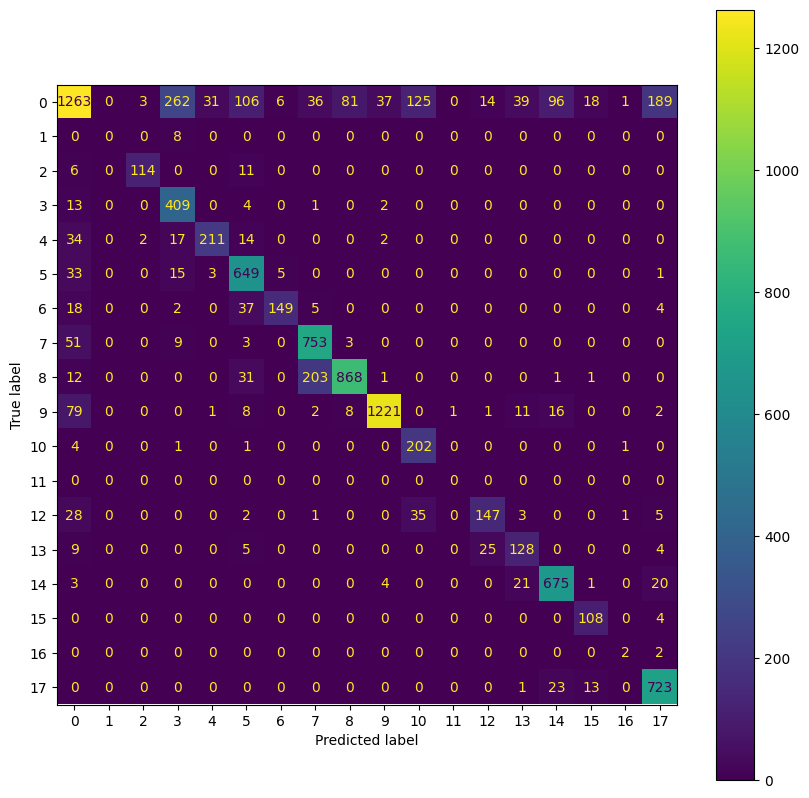

In [68]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
cm = confusion_matrix(df["gt_labels"], df["pred_labels"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm
                          )
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
